# __Take home task__


## Initial imports

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, ConfusionMatrixDisplay
import re
from collections import Counter
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForTokenClassification

## 1. Predictive modelling (binary classification)
In this section, I will perform the initial exploratory data analysis for feature engineering decisions and classification model choice. I'll use an XGBoost algorithm to predict the readmission of patients from a test set.


### Basic information extraction

In [ ]:
df = pd.read_csv("data.csv")
df.head()

In [6]:
# Basic info
print(df.info())
print(df.describe())

# check missing values
missing = df.isnull().sum()
print(missing[missing > 0])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               200 non-null    int64 
 1   age                      200 non-null    int64 
 2   gender                   200 non-null    object
 3   diagnosis_code           200 non-null    object
 4   num_previous_admissions  200 non-null    int64 
 5   medication_type          200 non-null    object
 6   length_of_stay           200 non-null    int64 
 7   readmitted_30_days       200 non-null    int64 
 8   discharge_note           200 non-null    object
dtypes: int64(5), object(4)
memory usage: 14.2+ KB
None
       patient_id         age  num_previous_admissions  length_of_stay  \
count  200.000000  200.000000               200.000000      200.000000   
mean   100.500000   53.720000                 1.600000        7.865000   
std     57.879185   21.294574      

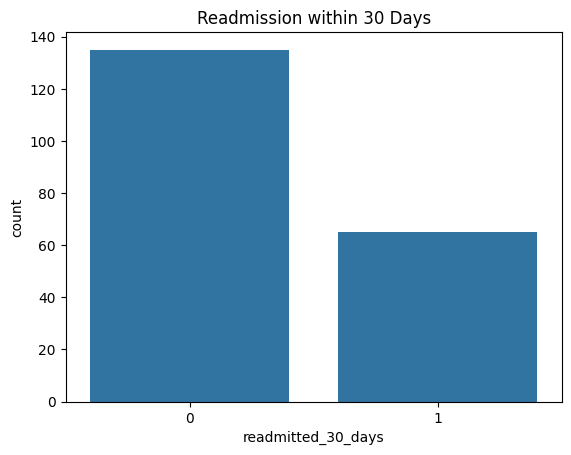

In [7]:
# Readmission distribution
sns.countplot(data=df, x='readmitted_30_days')
plt.title("Readmission within 30 Days")
plt.show()

No missing values in any of the columns, so keeping all dataframe rows.
Also, the ranges for age seem normal. The ranges for other numerical values also seem acceptable (e.g. no length of stay spanning months/years, however this could be possible, I wouldn't have much expertise about that...).
The rate of readmission to non-readmission within 30 days seems to be roughly 1/3.

### 1.2.1 Numerical features EDA

The patient_id number is removed from the correlation matrix, as it holds to relevance to the readmission of a patient (acts as a row number in the current dataframe format).

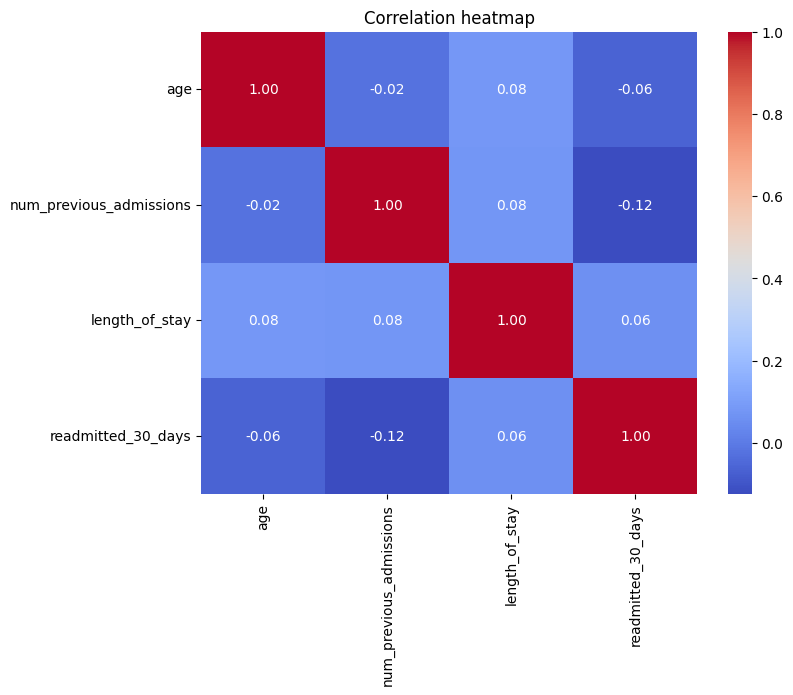

In [8]:
plt.figure(figsize=(8, 6))
corr_matrix = df.drop(columns=['patient_id']).corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation heatmap")
plt.show()


The number of previous admissions seems to exhibit the most correlation to being readmitted after 30 days, however this correlation is not very strong. I would still include it as a relevant feature in the binary classification model.

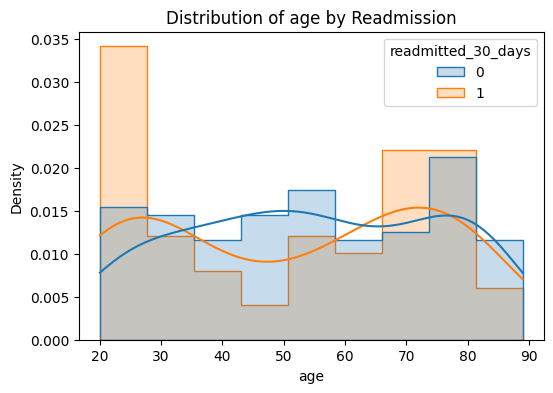

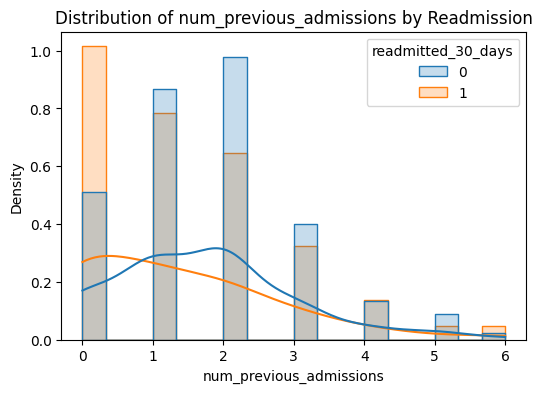

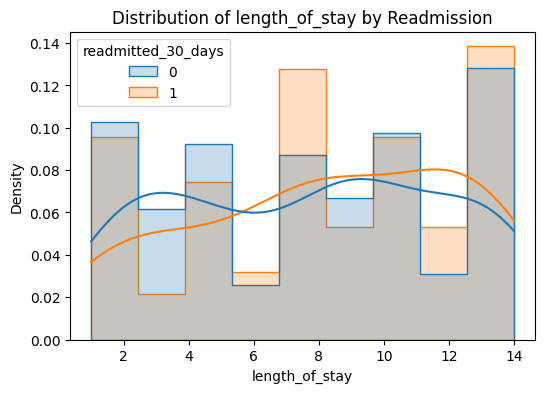

In [9]:
num_cols = ['age','num_previous_admissions','length_of_stay']
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=df, x=col, hue='readmitted_30_days', kde=True, element='step', stat='density', common_norm=False)
    plt.title(f"Distribution of {col} by Readmission")
    plt.show()


Younger patients seem to have a higher relative readmission rates. On its own, the age would not be a good predictor but it will be retained as a variable alongside other influencing factors for the classification. The same can be said about the significance of the number of previous admissions: those with no previous admissions are more likely to be readmitted relative to those who have had previous admissions.
The length of stay does highlight very weak correlation to readmission, however will be kept in modelling.

### 1.2.2 Categorical features EDA
For a simpler binary classification model, the unstructured text data (i.e. discharge notes) will be left out. Here, the gender, diagnosis code and medication type will be looked at in relation to the readmission status.

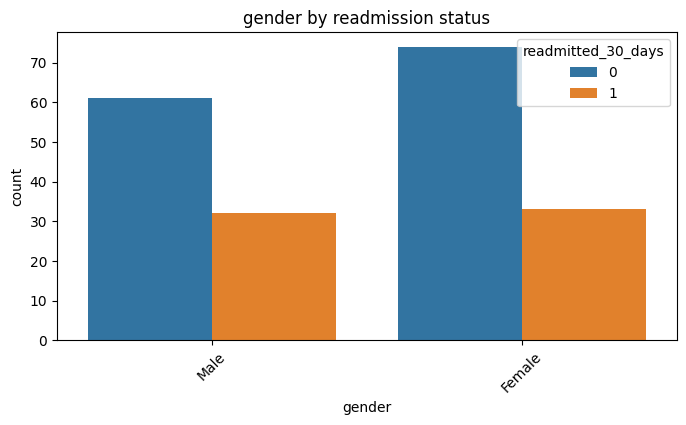

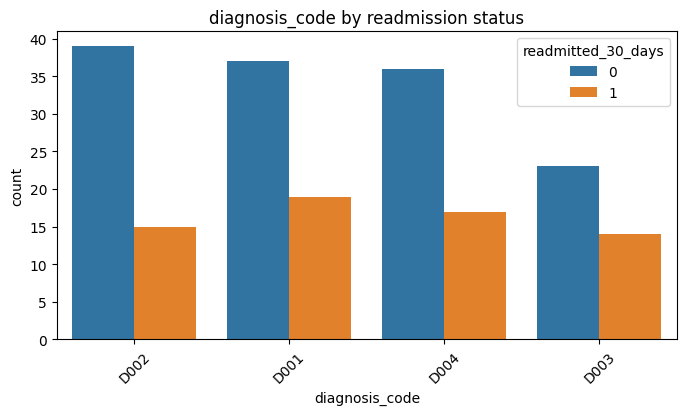

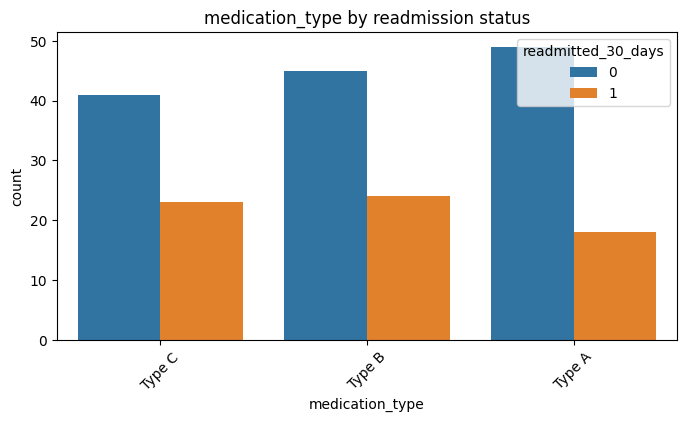

In [10]:
cat_cols = ['gender', 'diagnosis_code', 'medication_type']

for col in cat_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=col, hue='readmitted_30_days')
    plt.title(f"{col} by readmission status")
    plt.xticks(rotation=45)
    plt.show()


For gender, males and females have similar readmission counts but females have a higher non-readmission count. However, it does not appear to have a lot of predictive value on its own but will still be included in the variables for the binary classification.
The diagnosis code and medication type will definitely be kept as influencing variables for the classification, as the ratios of non readmission to readmission seem to be influenced by these features.

### 1.3 Feature engineering

As an additional feature, it may be useful to have a variable which considers both the diagnosis and prescribed medication type.

In [24]:
df['diagnosis_medication_combo'] = df['diagnosis_code'] + "_" + df['medication_type']


In [27]:
np.unique(df['diagnosis_medication_combo'])

array(['D001_Type A', 'D001_Type B', 'D001_Type C', 'D002_Type A',
       'D002_Type B', 'D002_Type C', 'D003_Type A', 'D003_Type B',
       'D003_Type C', 'D004_Type A', 'D004_Type B', 'D004_Type C'],
      dtype=object)

Checking for class imbalance for readmission status, we'll set a scale_pos_weight parameter.

In [29]:
class_distribution = y.value_counts(normalize=True)
print(class_distribution)

readmitted_30_days
0    0.675
1    0.325
Name: proportion, dtype: float64


In [30]:
scale_pos_weight = class_distribution[0] / class_distribution[1]
print(scale_pos_weight)

2.076923076923077


### 1.4 XGBoost

#### Without new feature (original data only)

In [38]:
y = df['readmitted_30_days']
x = df.drop(['readmitted_30_days', 'discharge_note', 'patient_id','diagnosis_medication_combo'], axis=1)
categorical_cols = x.select_dtypes(include='object').columns.tolist()
numerical_cols = x.select_dtypes(include=['int64', 'float64']).columns.tolist()

The categorical variables are converted to numerical variables using one-hot encoding.

In [39]:
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('cat', categorical_pipeline, categorical_cols),
    ('num', numerical_pipeline, numerical_cols)
])

In [40]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]

    print(classification_report(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
    print("F1 Score:", f1_score(y_test, y_pred))

    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
    plt.title("Confusion Matrix")
    plt.show()


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:31:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.71      0.71      0.71        41
           1       0.37      0.37      0.37        19

    accuracy                           0.60        60
   macro avg       0.54      0.54      0.54        60
weighted avg       0.60      0.60      0.60        60

ROC AUC: 0.5956354300385108
F1 Score: 0.3684210526315789


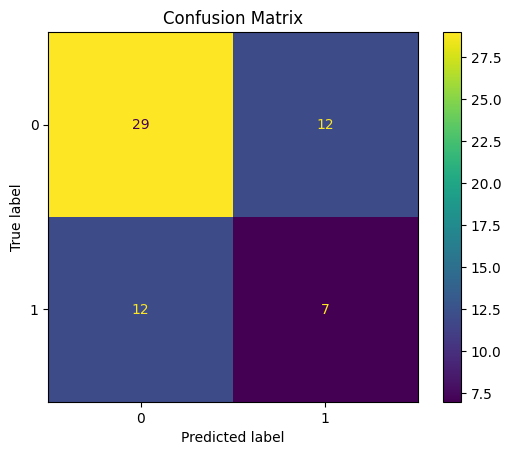

In [41]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, random_state=126)


xg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight))
])

evaluate_model(xg_pipeline, X_train, X_test, y_train, y_test)

The XGBoost using the original data only outperforms the other one, hence the analysis will be based on the results for this one.


The XGBoost model appears to perform better on the majority class (no readmission) whereas for the minority class (readmission) with 29/41 correct predictions (71%), it misclassified 12/19 cases (only 37% correct predictions). This can be attributed to the class imbalance in the dataset, but also to the overall data scarcity issue. The total dataset comprised 200 cases only, and with a 70-30 test split (which yielded the best results in the range of 0.15-0.35 test split), this only left 140 training samples. This is very small, especially if the goal is to capture features of a system as complex as the human body.

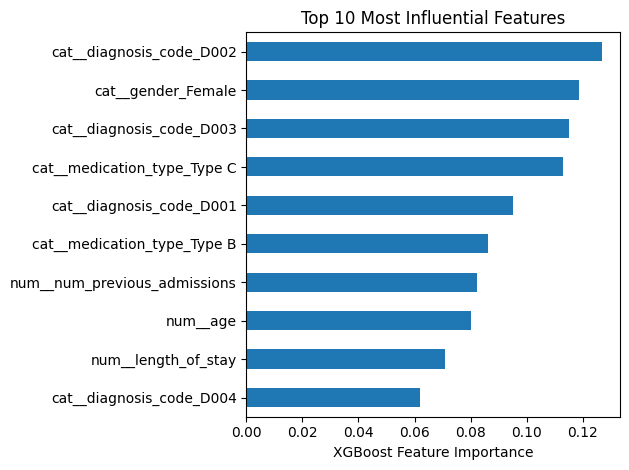

In [42]:
feature_names = xg_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Importance scores
importances = xg_pipeline.named_steps['classifier'].feature_importances_
importance_series = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Top 10
top_n = 10
importance_series.head(top_n).plot(kind='barh')
plt.title("Top 10 Most Influential Features")
plt.xlabel("XGBoost Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


The majority influential features were of the diagnosis and medication kind, as one would expect that the diagnosis and treatment of a patient would have a larger influence on whether or not they will be readmitted. It appears that gender was an influencing feature, as seen where females were relatively less likely to be readmitted than males (in the categorical exploratory data analysis).

#### With new feature

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:31:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.69      0.76      0.72        41
           1       0.33      0.26      0.29        19

    accuracy                           0.60        60
   macro avg       0.51      0.51      0.51        60
weighted avg       0.58      0.60      0.59        60

ROC AUC: 0.5738125802310655
F1 Score: 0.29411764705882354


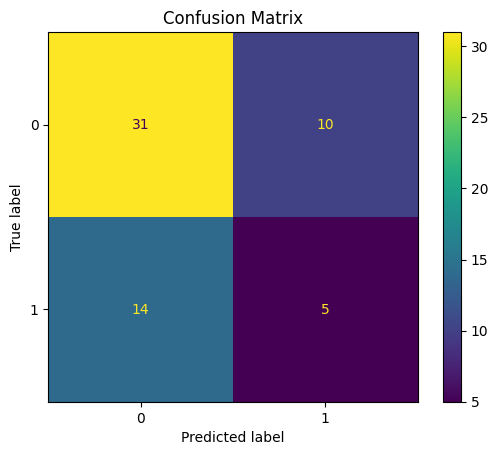

In [43]:
y = df['readmitted_30_days']
x = df.drop(['readmitted_30_days', 'discharge_note', 'patient_id'], axis=1)
categorical_cols = x.select_dtypes(include='object').columns.tolist()
numerical_cols = x.select_dtypes(include=['int64', 'float64']).columns.tolist()

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('cat', categorical_pipeline, categorical_cols),
    ('num', numerical_pipeline, numerical_cols)
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, random_state=126)


xg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight))
])

evaluate_model(xg_pipeline, X_train, X_test, y_train, y_test)

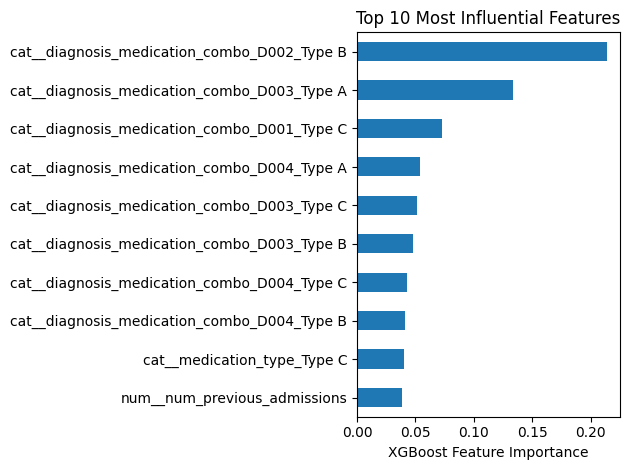

In [44]:
feature_names = xg_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Importance scores
importances = xg_pipeline.named_steps['classifier'].feature_importances_
importance_series = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Top 10
top_n = 10
importance_series.head(top_n).plot(kind='barh')
plt.title("Top 10 Most Influential Features")
plt.xlabel("XGBoost Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


The most influential features here seem to be the new feature combining the medication and diagnosis. It is possible that this actually worsens the results, because the model overfits to a small subsample of the dataset that is too specific (very few cases have these combinations), so this leads to poor generalisation.

## 2. Named entity recognition from discharge notes

For this task, I will be using a biomedical NER from HuggingFace (d4data/biomedical-ner-all), and using label entity mapping from the imported model to the required labels in the task.

In [45]:
tokenizer = AutoTokenizer.from_pretrained("d4data/biomedical-ner-all")
model = AutoModelForTokenClassification.from_pretrained("d4data/biomedical-ner-all")

pipe = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/373 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/5.00k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/266M [00:00<?, ?B/s]

Device set to use cpu


In [46]:
# Notes subset, check imported model labels
notes_subset = df['discharge_note'].dropna().head(10)

# Apply NER
ner_results = notes_subset.apply(lambda note: pipe(note))

df_subset = notes_subset.to_frame()
df_subset['d4data_entities'] = ner_results


In [47]:
# display options
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

print(df_subset[['discharge_note', 'd4data_entities']])


                                                            discharge_note                                                                                                                                                                                                                                                                                                                                                                         d4data_entities
0           Good recovery trajectory. Follow-up scan scheduled next month.                                                                                                                                                                                                                                                                                                                                                                                      []
1                 Stable post-surgery. Advised to avoid physical exertion.                        

The labels provided by this model do not match the ones requested in the task, so I will map out all the unique output labels to match as closely to the ones requested. However, for those that do not match, I will keep as is.

In [48]:
notes = df['discharge_note'].dropna()

# Run the model on all notes
ner_results = notes.apply(lambda note: pipe(note))

all_entity_groups = set()
for entities in ner_results:
    for ent in entities:
        all_entity_groups.add(ent['entity_group'])

# Unique labels
print(sorted(all_entity_groups))


['Clinical_event', 'Date', 'Diagnostic_procedure', 'Disease_disorder', 'Duration', 'Lab_value', 'Medication', 'Severity', 'Sign_symptom', 'Therapeutic_procedure']


In [49]:
d4data_to_custom = {
    'Clinical_event': 'Diagnosis',
    'Date': 'Date',
    'Diagnostic_procedure': 'Treatment',
    'Disease_disorder': 'Diagnosis',
    'Duration': 'Duration',
    'Lab_value': 'Lab_value',
    'Medication': 'Medications',
    'Severity': 'Severity',
    'Sign_symptom':'Symptoms',
    'Therapeutic_procedure': 'Treatment'
}


It should be noted that this model did not have any entity which related to follow up actions (as far as I can tell). However, it could fall under one of the therapeutic procedures or diagnostic procedure, as sometimes treatment can count as a follow up action, e.g. "rest for 2 weeks" or "scan in 4 weeks".

In [50]:
def map_d4data_entities(note):
    ents = pipe(note)
    return [(ent['word'], d4data_to_custom.get(ent['entity_group'], 'Other')) for ent in ents]

# Apply to subset or full data
df['mapped_d4data_entities'] = df['discharge_note'].dropna().apply(map_d4data_entities)


In [51]:
df['mapped_d4data_entities'].head()

,mapped_d4data_entities
0,[]
1,"[(stable, Lab_value)]"
2,"[(symptoms, Symptoms), (re, Treatment), (##lapse, Treatment)]"
3,"[(stable, Lab_value)]"
4,"[(stable, Lab_value)]"


In [52]:
print(df[['discharge_note', 'mapped_d4data_entities']].head(10))

                                                            discharge_note                                                          mapped_d4data_entities
0           Good recovery trajectory. Follow-up scan scheduled next month.                                                                              []
1                 Stable post-surgery. Advised to avoid physical exertion.                                                           [(stable, Lab_value)]
2                     Symptoms controlled. Monitoring for relapse advised.                   [(symptoms, Symptoms), (re, Treatment), (##lapse, Treatment)]
3                 Stable post-surgery. Advised to avoid physical exertion.                                                           [(stable, Lab_value)]
4                 Stable post-surgery. Advised to avoid physical exertion.                                                           [(stable, Lab_value)]
5           Good recovery trajectory. Follow-up scan scheduled next mo

The assignment of relevant labels was partially successful, in that it did identify key words and terms within the discharge note and assign it a label.
However, the labels were often incorrect or misleading. For example 'follow' was labelled as diagnosis, due to using a model which did not have an entity group for follow up actions to map to. Another example of error is the assignment of the label treatment to 'blood pressure'. Also, the model I used did not have the same entity labels as the task instructions, and mapping their labels to the ones here introduced ambiguity. And finally, due to the lack of follow up action labels, some discharge notes were not assigned any labels at all as they did not include any other entity aside from a future action or a prognosis.
For example, a term like “surgery” could refer to a symptom (e.g. a previous surgery causing issue), treatment (e.g. a treatment for the diagnosis), or follow-up (e.g. a surgery later on if need be) depending on the phrasing, but the model doesn’t have that level of contextual understanding. This highlights the importance of model selection for entity recognition, but also the model’s ability to recognise the word or term in the broader context and not just matching keywords. It's also understanding how they function within a clinical/medical specific narrative.
Finally, LLM hallucinations in this type of task could look like the model assigning a diagnosis or medication label to a word that doesn’t clearly refer to one in the discharge note. For example, discharge note 7 (index 6) says:
'Discharge after recovery from pneumonia. No complications observed.' and the model assigned the following labels: [(discharge, Diagnosis), (complications, Diagnosis)]. It categorised discharge and complications as a diagnosis, when really the context of the note is a positive prognosis, and the key word for the original diagnosis is pneumonia, which was not labelled at all. This kind of error shows up when the model misses/misidentifies terms and fills in gaps based on assumption rather than context, which carries a lot of risk in clinical settings. So even when the labels seem reasonable we can’t assume correctness without human input and oversight.
